In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, GlobalMaxPool1D, Dense


In [6]:
# Set GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
## Load dataset
df = pd.read_table('FinancialPhraseBank-v1.0/Sentences_50Agree.txt', delimiter='\r\n', engine='python', encoding='ISO-8859-1')
values = np.array([df.values[i][0].split('@') for i in range(df.size)])
data = pd.DataFrame({'sentence':values[:, 0], 'sentiment':values[:, 1]})

# Show first rows
data.head()

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


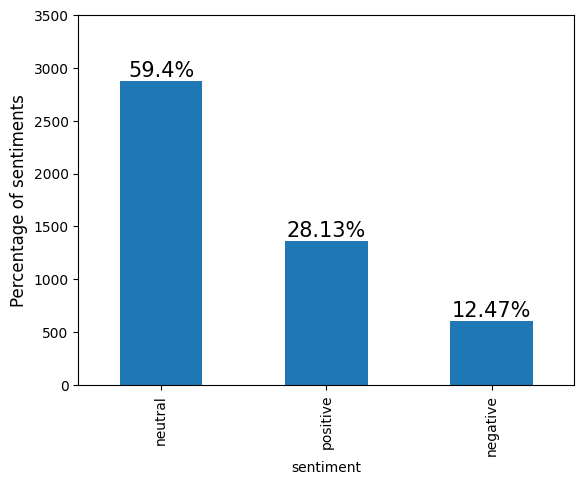

In [13]:
# Visualize the target distribution
ax = data['sentiment'].value_counts().plot(kind='bar')
ax.set_ylabel('Percentage of sentiments', fontsize=12)
ax.set_yticks(np.arange(0, 3501, 500))

# Print percents per class
total = data['sentiment'].size
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height() + 40, str(round((i.get_height()/total)*100, 2)) + '%', ha ='center', fontsize=15)
plt.show()

In [36]:
## Split dataset into training and testing sets
X = data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
y_train.shape

(3876,)

In [37]:
## Tokenize training and testing sets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print("Number of words: {}".format(len(word_index)))


Number of words: 8976


In [38]:
print(X_train)
print(word_index)

[[1, 1764, 2, 1, 4371, 33, 5, 374, 2413, 14, 1, 2006, 29, 1, 143, 1382, 29, 263, 182, 1547, 33, 391, 546, 103, 1, 1382, 29, 676, 182, 1547], [6, 129, 169, 51, 4372, 141, 2, 392, 18, 804, 40, 122, 3, 1, 2007, 393, 13, 47, 1155, 5, 47, 1548, 79, 54], [307, 1383, 5, 2414, 59, 34, 13, 4373, 50, 34, 324, 5, 1156, 110, 437, 977, 3, 1, 161, 53, 4, 1, 1264, 210, 2, 15, 49], [46, 279, 200, 24, 714, 179, 805, 186, 325, 461, 58, 105, 2008, 21, 547, 15, 31, 30, 3001, 5, 1384, 59, 34, 3, 51, 13, 3002, 62, 3, 41, 4, 28, 2009, 15, 393, 1385], [1067, 288, 117, 5, 1068, 1265, 13, 180, 227], [3003, 438, 10, 1, 914, 7, 6, 2010, 88, 1549, 978, 462, 7, 39, 806, 189, 16, 1, 83, 307, 2, 15, 98, 4374, 5, 1386, 37, 46, 492, 63, 21, 4375, 415, 4376, 361, 2, 1, 3004, 141, 2, 3003, 438, 4, 4377], [1, 1157, 152, 12, 20, 2415, 17, 181, 190, 51, 1, 1550, 11, 21], [4378, 142, 18, 151, 73, 4379, 187, 1, 631, 2, 3005, 142, 4, 1, 2011, 394, 187, 1, 1069, 113], [1070, 632, 71, 337, 44, 56, 439, 866, 6, 915, 1158, 2, 1, 9

In [39]:
# Pad the sequences
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [40]:
print(X_train)

[[   0    0    0 ...  676  182 1547]
 [   0    0    0 ... 1548   79   54]
 [   0    0    0 ...    2   15   49]
 ...
 [   0    0    0 ...   13  180 1362]
 [   0    0    0 ... 4217  626  337]
 [   0    0    0 ... 8976  124 1122]]


In [41]:
# Encode target values as integers
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

print(y_train)

[1 2 2 ... 2 1 0]


In [42]:
# Convert integers to one hot encoded
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_classes = y_train.shape[1]
print(y_train, n_classes)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]] 3


In [49]:
# Embedding size
EMBEDDING_DIM = 300

## Create the model
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
## Compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [52]:
## Train the model
batch_size = 64
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

In [53]:
## Compute the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

print("Testing accuracy: {:.1f}".format(test_acc * 100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - acc: 0.6814 - loss: 0.8822
Testing accuracy: 66.8


In [54]:
## Make predictions
y_pred = model.predict(X_test, batch_size=batch_size)

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set options to print 2 decimals
np.set_printoptions(precision=2)

In [56]:
def plot_confusion_matrix(cm, classes, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

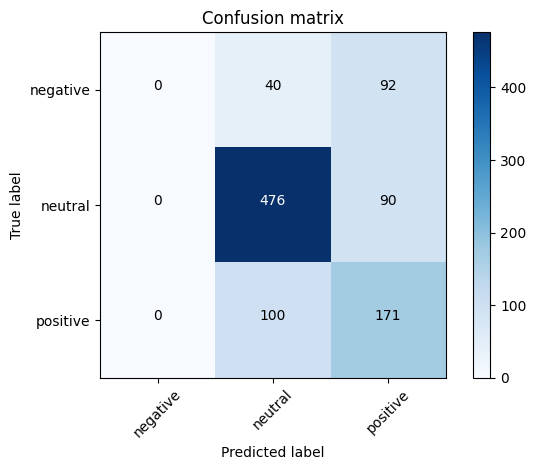

In [57]:
labels = le.classes_.tolist()

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labels)

In [58]:
# Precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test, y_pred, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=labels)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.000     0.000       0.000        132
neutral         0.773     0.841       0.805        566
positive        0.484     0.631       0.548        271


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
